In [ ]:
import requests
import json
import time
import os
import math
from datetime import datetime, timedelta

from tqdm import tqdm

"""Функция, которая записывает в vacancies полученные данные по запросу к API "Работа России""""

def getDay(modifiedFrom: datetime):

    modifiedTo = modifiedFrom + timedelta(hours=1)
    params = {
        'modifiedFrom': f"{modifiedFrom.strftime('%Y-%m-%d')}T{modifiedFrom.hour}:00:00Z",
        'modifiedTo': f"{modifiedTo.strftime('%Y-%m-%d')}T{modifiedTo.hour}:00:00Z",
        'limit': 100,
        'offset': 0
    }

    req = requests.get('http://opendata.trudvsem.ru/api/v1/vacancies', params)
    data = json.loads(req.content.decode())
    req.close()
    if data['results']:
        vacancies = data['results']['vacancies']
    else:
        vacancies = []
    total = int(data['meta']['total'])
    if total > 10000:
        raise Exception('total more than 10000')
    for _ in tqdm(range(math.ceil(total // 100))):
        time.sleep(0.1)
        params['offset'] += 1
        req = requests.get('http://opendata.trudvsem.ru/api/v1/vacancies', params)
        data = json.loads(req.content.decode())
        req.close()
        if data['results']:
            vacancies += data['results']['vacancies']
    return vacancies

# cобираем данные с 10 марта 2022 года (по дате раньше API не выдает данные), 
# итерируясь по 1 часу из-за ограничения на количество данных по 10000 записей за запрос

start_time = datetime(year=2022, month=03, day=10)
end_time = datetime(year=2022, month=5, day=1)

vacancies = []

while start_time < end_time:
    try:
        vacancies += getDay(start_time)
    except Exception as e:
        print(e)
        with open('backup.json', 'w') as file:
            json.dump(vacancies, file)
            break
    start_time += timedelta(hours=1)
    print(start_time)

In [ ]:
"""Сохраняем данные в json-файл"""
with open('full_data.json', 'w') as file:
    json.dump(vacancies, file)

In [ ]:
"""Преобразуем json-файл в датафрейм"""
import pandas as pd
import json

with open('full_data.json', 'r') as file:
    df = pd.json_normalize(json.load(file))

In [1]:
import pandas as pd
import json

with open('first_data.json', 'r') as file1:
    df1 = pd.json_normalize(json.load(file1))

with open('second_data.json', 'r') as file2:
    df2 = pd.json_normalize(json.load(file2))

with open('third_data.json', 'r') as file3:
    df3 = pd.json_normalize(json.load(file3))

df4 = pd.concat([df1, df2], sort = False, axis = 0)
df = pd.concat([df4, df3], sort = False, axis = 0)

In [3]:
df["vacancy.category.specialisation"].value_counts()

Производство                                                        112474
Здравоохранение и социальное обеспечение                             61924
Образование, наука                                                   48972
Продажи, закупки, снабжение, торговля                                34398
Транспорт, автобизнес, логистика, склад, ВЭД                         24753
ЖКХ, эксплуатация                                                    20474
Строительство, ремонт, стройматериалы, недвижимость                  19229
Пищевая промышленность                                               18325
Сельское хозяйство, экология, ветеринария                            15853
Консалтинг, стратегическое развитие, управление                      15020
Работы, не требующие квалификации                                    11599
Рабочие специальности                                                 9846
Добывающая промышленность                                             8708
Информационные технологии

In [50]:
"""Выбираем нужные специализации"""

df_filtered = df[(df["vacancy.category.specialisation"] == "Информационные технологии, телекоммуникации, связь") 
| (df["vacancy.category.specialisation"] == "Искусство, культура и развлечения") | 
(df["vacancy.category.specialisation"] == "Безопасность, службы охраны") | 
(df["vacancy.category.specialisation"] == "Государственная служба, некоммерческие организации")]
df_filtered

,vacancy.id,vacancy.source,vacancy.region.region_code,vacancy.region.name,vacancy.company.ogrn,vacancy.company.site,vacancy.company.companycode,vacancy.company.hr-agency,vacancy.company.inn,vacancy.company.name,...,vacancy.term.text,vacancy.currency,vacancy.salary_max,vacancy.company.phone,vacancy.company.email,vacancy.company.logo,vacancy.social_protected,vacancy.company.fax,vacancy.company.code_industry_branch,vacancy.category.industry
66,b74fc5b2-59f9-11ec-b40f-bf2cfe8c828d,Служба занятости,5400000000000,Новосибирская область,1025401504039,http://nokkii.ru/,1025401504039,False,5404131424,Государственное автономное профессиональное об...,...,Социальный пакет,«руб.»,30000,+7(383)3464043 доб. 249,ok-nokkii@mail.ru,NaN,NaN,NaN,NaN,NaN
115,8e6790c2-a16a-11ec-add7-bf2cfe8c828d,Служба занятости,5200000000000,Нижегородская область,1025202210538,NaN,1025202210538,False,5201004100,"Отдел по вопросам культуры, спорта и молодежи ...",...,Социальный пакет,«руб.»,13890,+7(83179)53195,kultura.ardatov@yandex.ru,NaN,NaN,NaN,NaN,NaN
141,6d1bb722-e36f-11eb-9dd6-bf2cfe8c828d,Служба занятости,4200000000000,Кемеровская область,1034205018110,http://lad-dva.ru,1034205018110,False,4206002915,"ООО ""КОМПАНИЯ ЛАД-ДВА""",...,Социальный пакет- График работы - понедельник-...,«руб.»,0,+7(3842)744444,kassa@lad-dva.ru,NaN,NaN,NaN,NaN,NaN
191,e11d2ef3-7d4e-11ec-b378-bf2cfe8c828d,Служба занятости,3600000000000,Воронежская область,1023600511448,NaN,1023600511448,False,3662180590,"ОВО ПО ПАНИНСКОМУ РАЙОНУ-ФИЛИАЛ ФГКУ ""УВО ВНГ ...",...,"Социальный пакетОФОРМЛЕНИЕ ПО ТК,СОЦ.ПАКЕТ",«руб.»,13890,+7(47344)4-71-82,panino_ovo@mail.ru,NaN,NaN,NaN,NaN,NaN
243,3c72e332-9fd7-11ec-add7-bf2cfe8c828d,Служба занятости,2300000000000,Краснодарский край,1022304246502,NaN,1022304246502,False,2340015390,ГОСУДАРСТВЕННОЕ КАЗЕННОЕ УЧРЕЖДЕНИЕ КРАСНОДАРС...,...,Социальный пакет,«руб.»,25000,+7(86168)54993,cb_kushev@mtsr.krasnodar.ru,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359290,12fe3323-b2fa-11ec-9aad-bf2cfe8c828d,Служба занятости,1800000000000,Удмуртская Республика,1021801509828,NaN,1021801509828,False,1833000800,"КПОУ УР ""Удмуртский республиканский колледж ку...",...,Социальный пакет,«руб.»,15974,+7(3412)444491,urkkult@mail.ru,NaN,NaN,+7(3412)444491,NaN,NaN
359309,eab00b13-0042-11ec-9dd6-bf2cfe8c828d,Служба занятости,5200000000000,Нижегородская область,1025203047385,NaN,1025203047385,False,5260070545,"Муниципальное бюджетное учреждение культуры ""Н...",...,Социальный пакетРазделенный на части рабочий день,«руб.»,33800,+7(831)4308173,komedi@mail.ru,NaN,NaN,+7(831)4331476,NaN,NaN
359310,8351b2d3-0c71-11ec-9dd6-bf2cfe8c828d,Служба занятости,5200000000000,Нижегородская область,1025203047385,NaN,1025203047385,False,5260070545,"Муниципальное бюджетное учреждение культуры ""Н...",...,Социальный пакет,«руб.»,16949,+7(831)4308173,komedi@mail.ru,NaN,NaN,+7(831)4331476,NaN,NaN
359323,8729ed62-9664-11eb-9dd6-bf2cfe8c828d,Служба занятости,5500000000000,Омская область,1115543001056,NaN,1115543001056,False,5519200201,"БУ ЛМР ""ЦКИ ЛМР""",...,Социальный пакет,«руб.»,23000,+721396,lubino-admkult@yandex.ru,NaN,NaN,NaN,NaN,NaN


In [186]:
df_filtered["vacancy.category.specialisation"].value_counts()

Информационные технологии, телекоммуникации, связь    8624
Государственная служба, некоммерческие организации    7450
Искусство, культура и развлечения                     7440
Безопасность, службы охраны                           4928
Name: vacancy.category.specialisation, dtype: int64

In [51]:
df_filtered = df_filtered.reset_index().drop(columns = ['index'])

In [52]:
"""Преобразуем время в формат datetime"""
from datetime import datetime

def change_date(x):
    try:
        date = datetime.strptime(x, "%Y-%m-%d")
        
    except Exception as e: # нам известно о двух ошибках в записи времени
         # если не получилось преобразовать в datetime, то исправляем эти две ошибки 
        if x == "333322-03-11":
            return datetime.strptime('2022-03-11', "%Y-%m-%d")
        return datetime.strptime('2022-03-28', "%Y-%m-%d")
        
    return date
    
df_filtered["vacancy.creation-date"] = df_filtered["vacancy.creation-date"].apply(change_date)

In [56]:
"""Валидируем корректность даты"""

def clean_date(x):
    if x > datetime.strptime('2022-05-01', "%Y-%m-%d"):
        return None
    elif x < datetime.strptime('2016-01-01', "%Y-%m-%d"):
        return None
    return x

df_filtered["vacancy.creation-date"] = df_filtered["vacancy.creation-date"].apply(clean_date)

In [58]:
df_result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28366 entries, 0 to 28441
Data columns (total 35 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   vacancy.id                            28366 non-null  object        
 1   vacancy.source                        28366 non-null  object        
 2   vacancy.region.region_code            28366 non-null  object        
 3   vacancy.region.name                   28366 non-null  object        
 4   vacancy.company.ogrn                  28353 non-null  object        
 5   vacancy.company.site                  6925 non-null   object        
 6   vacancy.company.companycode           28363 non-null  object        
 7   vacancy.company.hr-agency             28363 non-null  object        
 8   vacancy.company.inn                   28325 non-null  object        
 9   vacancy.company.name                  28342 non-null  object        
 10

In [57]:
first_date = datetime.strptime('2016-01-01', "%Y-%m-%d") 
end_date = datetime.strptime('2022-05-01', "%Y-%m-%d")
df_result = df_filtered.loc[(df_filtered["vacancy.creation-date"] < end_date) & (df_filtered["vacancy.creation-date"] > first_date)]
df_result

,vacancy.id,vacancy.source,vacancy.region.region_code,vacancy.region.name,vacancy.company.ogrn,vacancy.company.site,vacancy.company.companycode,vacancy.company.hr-agency,vacancy.company.inn,vacancy.company.name,...,vacancy.term.text,vacancy.currency,vacancy.salary_max,vacancy.company.phone,vacancy.company.email,vacancy.company.logo,vacancy.social_protected,vacancy.company.fax,vacancy.company.code_industry_branch,vacancy.category.industry
0,b74fc5b2-59f9-11ec-b40f-bf2cfe8c828d,Служба занятости,5400000000000,Новосибирская область,1025401504039,http://nokkii.ru/,1025401504039,False,5404131424,Государственное автономное профессиональное об...,...,Социальный пакет,«руб.»,30000,+7(383)3464043 доб. 249,ok-nokkii@mail.ru,NaN,NaN,NaN,NaN,NaN
1,8e6790c2-a16a-11ec-add7-bf2cfe8c828d,Служба занятости,5200000000000,Нижегородская область,1025202210538,NaN,1025202210538,False,5201004100,"Отдел по вопросам культуры, спорта и молодежи ...",...,Социальный пакет,«руб.»,13890,+7(83179)53195,kultura.ardatov@yandex.ru,NaN,NaN,NaN,NaN,NaN
2,6d1bb722-e36f-11eb-9dd6-bf2cfe8c828d,Служба занятости,4200000000000,Кемеровская область,1034205018110,http://lad-dva.ru,1034205018110,False,4206002915,"ООО ""КОМПАНИЯ ЛАД-ДВА""",...,Социальный пакет- График работы - понедельник-...,«руб.»,0,+7(3842)744444,kassa@lad-dva.ru,NaN,NaN,NaN,NaN,NaN
3,e11d2ef3-7d4e-11ec-b378-bf2cfe8c828d,Служба занятости,3600000000000,Воронежская область,1023600511448,NaN,1023600511448,False,3662180590,"ОВО ПО ПАНИНСКОМУ РАЙОНУ-ФИЛИАЛ ФГКУ ""УВО ВНГ ...",...,"Социальный пакетОФОРМЛЕНИЕ ПО ТК,СОЦ.ПАКЕТ",«руб.»,13890,+7(47344)4-71-82,panino_ovo@mail.ru,NaN,NaN,NaN,NaN,NaN
4,3c72e332-9fd7-11ec-add7-bf2cfe8c828d,Служба занятости,2300000000000,Краснодарский край,1022304246502,NaN,1022304246502,False,2340015390,ГОСУДАРСТВЕННОЕ КАЗЕННОЕ УЧРЕЖДЕНИЕ КРАСНОДАРС...,...,Социальный пакет,«руб.»,25000,+7(86168)54993,cb_kushev@mtsr.krasnodar.ru,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28437,12fe3323-b2fa-11ec-9aad-bf2cfe8c828d,Служба занятости,1800000000000,Удмуртская Республика,1021801509828,NaN,1021801509828,False,1833000800,"КПОУ УР ""Удмуртский республиканский колледж ку...",...,Социальный пакет,«руб.»,15974,+7(3412)444491,urkkult@mail.ru,NaN,NaN,+7(3412)444491,NaN,NaN
28438,eab00b13-0042-11ec-9dd6-bf2cfe8c828d,Служба занятости,5200000000000,Нижегородская область,1025203047385,NaN,1025203047385,False,5260070545,"Муниципальное бюджетное учреждение культуры ""Н...",...,Социальный пакетРазделенный на части рабочий день,«руб.»,33800,+7(831)4308173,komedi@mail.ru,NaN,NaN,+7(831)4331476,NaN,NaN
28439,8351b2d3-0c71-11ec-9dd6-bf2cfe8c828d,Служба занятости,5200000000000,Нижегородская область,1025203047385,NaN,1025203047385,False,5260070545,"Муниципальное бюджетное учреждение культуры ""Н...",...,Социальный пакет,«руб.»,16949,+7(831)4308173,komedi@mail.ru,NaN,NaN,+7(831)4331476,NaN,NaN
28440,8729ed62-9664-11eb-9dd6-bf2cfe8c828d,Служба занятости,5500000000000,Омская область,1115543001056,NaN,1115543001056,False,5519200201,"БУ ЛМР ""ЦКИ ЛМР""",...,Социальный пакет,«руб.»,23000,+721396,lubino-admkult@yandex.ru,NaN,NaN,NaN,NaN,NaN


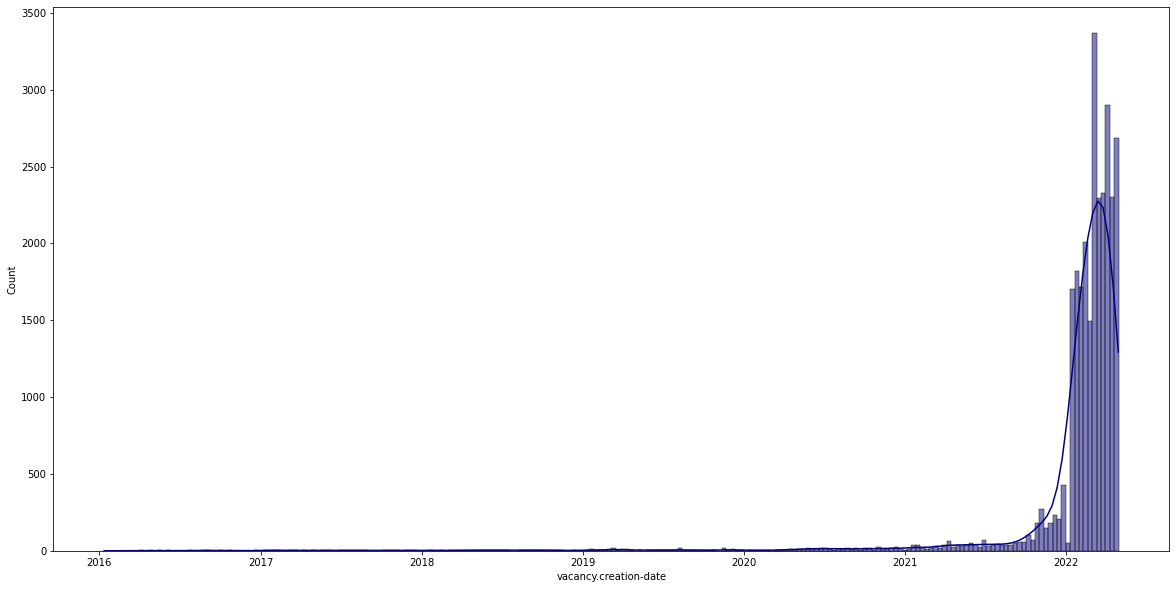

In [61]:
"""Визуализируем распредение вакансий по времени создания"""
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 10))
sns.histplot(data=df_result, x='vacancy.creation-date', color = 'navy', binwidth = 10, kde = True)
plt.show()

In [ ]:
df_result.to_json('result_data.json')
df_result.to_csv('result_data.csv')